In [3]:
# Import packages

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.neighbors import KernelDensity
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.optim as optim

import math

### Part B
Variational Autoencoder (VAE) on sklearn digits

In [4]:
# Load data
digits = load_digits()
X = digits.data.astype(np.float32) / 16.0   # scale 0–1
data = torch.from_numpy(X)

# Params
input_dim = 64
latent_dim = 10
device = "cuda" if torch.cuda.is_available() else "cpu"

Epoch 0: Loss = 19105.00
Epoch 1: Loss = 12747.27
Epoch 2: Loss = 9339.60
Epoch 3: Loss = 8737.86
Epoch 4: Loss = 8651.22
Epoch 5: Loss = 8585.92
Epoch 6: Loss = 8571.90
Epoch 7: Loss = 8552.10
Epoch 8: Loss = 8536.70
Epoch 9: Loss = 8523.88
Epoch 10: Loss = 8530.01
Epoch 11: Loss = 8517.59
Epoch 12: Loss = 8511.92
Epoch 13: Loss = 8519.88
Epoch 14: Loss = 8505.14
Epoch 15: Loss = 8504.29
Epoch 16: Loss = 8509.87
Epoch 17: Loss = 8516.15
Epoch 18: Loss = 8493.53
Epoch 19: Loss = 8492.49
Epoch 20: Loss = 8491.07
Epoch 21: Loss = 8505.56
Epoch 22: Loss = 8493.23
Epoch 23: Loss = 8489.10
Epoch 24: Loss = 8496.26
Epoch 25: Loss = 8500.58
Epoch 26: Loss = 8475.95
Epoch 27: Loss = 8488.47
Epoch 28: Loss = 8487.47
Epoch 29: Loss = 8477.23
Epoch 30: Loss = 8491.07
Epoch 31: Loss = 8462.49
Epoch 32: Loss = 8478.67
Epoch 33: Loss = 8474.51
Epoch 34: Loss = 8458.87
Epoch 35: Loss = 8486.01
Epoch 36: Loss = 8480.45
Epoch 37: Loss = 8475.69
Epoch 38: Loss = 8465.81
Epoch 39: Loss = 8433.05
Epoch 40

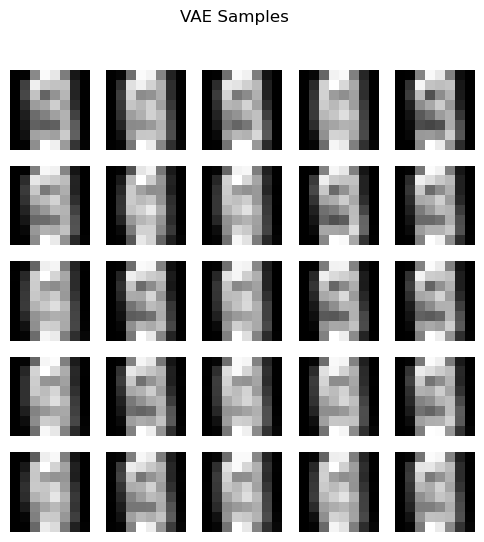

In [5]:
# Encoder + Decoder
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
        )
        self.mu = nn.Linear(64, latent_dim)
        self.logvar = nn.Linear(64, latent_dim)

    def forward(self, x):
        h = self.net(x)
        return self.mu(h), self.logvar(h)

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.net(z)

# VAE model
encoder = Encoder().to(device)
decoder = Decoder().to(device)

opt = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)

def loss_fn(x, recon_x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl

# Training
epochs = 50
batch_size = 128
n = len(data)

for epoch in range(epochs):
    perm = torch.randperm(n)
    total_loss = 0

    for i in range(0, n, batch_size):
        idx = perm[i:i+batch_size]
        x = data[idx].to(device)

        mu, logvar = encoder(x)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        recon = decoder(z)

        loss = loss_fn(x, recon, mu, logvar)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item()

    print(f"Epoch {epoch}: Loss = {total_loss:.2f}")

# Generate samples
z = torch.randn(25, latent_dim).to(device)
samples = decoder(z).cpu().detach().numpy()

fig, axes = plt.subplots(5, 5, figsize=(6, 6))
for ax, img in zip(axes.flatten(), samples):
    ax.imshow(img.reshape(8, 8), cmap='gray')
    ax.axis("off")

plt.suptitle("VAE Samples")
plt.show()
